In [2]:
%matplotlib inline
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import seaborn as sns

from dmba import regressionSummary, exhaustive_search, liftChart, gainsChart
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

## 6.1

#### a.

예측 성능을 평가하기 위해 데이터를 둘로 나눠 학습 데이터로는 모델을 구축하고 검증 데이터로는 구축된 모델의 성능을 평가한다.

In [3]:
housing_df = pd.read_csv('D:\숙탯 2기\dmba-datasets\BostonHousing.csv')

predictors = ['CRIM', 'CHAS', 'RM']
outcome = 'MEDV'

# partition data
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.4, random_state=1)

housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)

# print coefficients(계수)
print('intercept ', housing_lm.intercept_)  #intercept : 절편
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': housing_lm.coef_}))

intercept  -29.193467430606812
  Predictor  coefficient
0      CRIM    -0.240062
1      CHAS     3.266817
2        RM     8.325175


#### b.
yhat = -29 - 0.24*CRIM* + 3.27*CHAS* + 8.33*RM*

#### c.

In [4]:
x = pd.DataFrame([[0, 0.1, 6]],
                columns=['CHAS', 'CRIM', 'RM'])
x

y = pd.DataFrame([{'CHAS':0, 'CRIM':1, 'RM': 2})
y

,CHAS,CRIM,RM
0,0,1,2


In [150]:
print("주택가격 중앙값의 예측값:", housing_lm.predict(x)[0])

주택가격 중앙값의 예측값: 21.08426607875405


In [151]:
housing_df.loc[(housing_df['CHAS'] == 0) & (housing_df['CRIM'] == 0.1) & (housing_df['RM']==6)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV


In [152]:
housing_lm.predict(valid_X).mean()

23.04270768176427

In [153]:
valid_y.mean()

23.160098522167488

약 2천 달러

#### d.

i.

* RM, TAX, LSTAT 등이 동일한 것을 측정할 것 같다.
* 변수에 대한 설명만으로는 정확한 관계를 예상하기 어려우므로 상관계수로 관계를 알아보아야 한다.

ii.

##### 상관계수 데이터프레임

In [7]:
housing_df_corr = housing_df.drop(columns=['MEDV']).corr()
housing_df_corr

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,CAT. MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.151987
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.365296
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.366276
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.108631
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.232502
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.641265
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.191196
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.118887
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.197924
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.273687


##### 히트맵

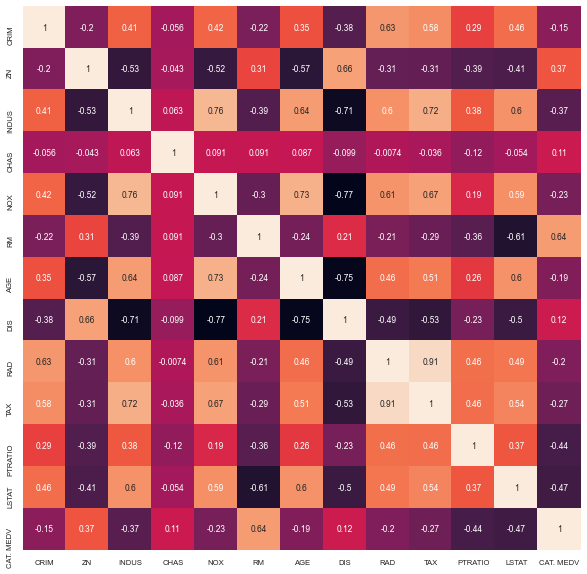

In [8]:
plt.figure(figsize=(10,10))
sns.set(font_scale=0.7)
sns.heatmap(housing_df_corr, annot=True, cbar=False)
plt.show()

##### 상관계수의 절댓값 크기순 데이터프레임

In [8]:
s = housing_df_corr.unstack()   # s는 Series

In [9]:
df = pd.DataFrame(s[s < 1].abs().sort_values(ascending=False), columns=['corr'])   # 상관계수의 절댓값 크기순으로 정렬
df.style.background_gradient(cmap='viridis')    # style.background_gradient : 데이터프레임에 색 입힐 수 있음.

상관계수의 절댓값이 0.7 이상인 변수 쌍 : (RAD, TAX), (NOX, DIS), (NOX, INDUS), (DIS, AGE), (NOX, AGE), (TAX, INDUS), (DIS, INDUS)  
RAD와 TAX 중 하나는 제거해야 하는 것으로 보임.

iii.

In [10]:
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'CAT. MEDV']
outcome = 'MEDV'

# partition data
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.4, random_state=1)

In [14]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)    # 보이는 너비 100으로 설정.
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))).sort_values(by
                                                                                                  = ['r2adj'], ascending=False))
pd.reset_option('display.width')

     n     r2adj          AIC    AGE  CAT. MEDV   CHAS   CRIM    DIS  INDUS  LSTAT    NOX  \
10  11  0.833103  1660.021045  False       True   True   True   True   True   True   True   
11  12  0.832716  1661.680840  False       True   True   True   True   True   True   True   
12  13  0.832228  1663.515572   True       True   True   True   True   True   True   True   
9   10  0.831941  1661.163238  False       True   True   True   True   True   True   True   
8    9  0.831819  1660.418877  False       True   True   True   True  False   True   True   
7    8  0.830529  1661.766431  False       True   True   True   True  False   True   True   
6    7  0.826096  1668.619824  False       True  False   True   True  False   True   True   
5    6  0.821125  1676.183684  False       True  False   True   True  False   True   True   
4    5  0.814675  1685.940421  False       True   True   True  False  False   True  False   
3    4  0.810106  1692.338134  False       True   True   True  False  

** 첫번째 모델(AGE, ZN 제거)

In [91]:
predictors = ['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'CAT. MEDV']
outcome = 'MEDV'

# partition data
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.4, random_state=1)

housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)   #학습 데이터에 대한 모델 구축

# print performance measures
regressionSummary(valid_y, housing_lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.4505
       Root Mean Squared Error (RMSE) : 3.8674
            Mean Absolute Error (MAE) : 2.7724
          Mean Percentage Error (MPE) : -2.1963
Mean Absolute Percentage Error (MAPE) : 13.3441


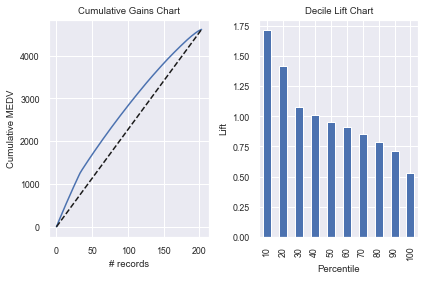

In [92]:
pred_y = pd.Series(housing_lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative MEDV')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

** 두번째 모델(AGE 제거)

In [93]:
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'CAT. MEDV']
outcome = 'MEDV'

# partition data
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.4, random_state=1)

housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)   #학습 데이터에 대한 모델 구축

# print performance measures
regressionSummary(valid_y, housing_lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.4361
       Root Mean Squared Error (RMSE) : 3.8786
            Mean Absolute Error (MAE) : 2.7704
          Mean Percentage Error (MPE) : -2.2655
Mean Absolute Percentage Error (MAPE) : 13.3202


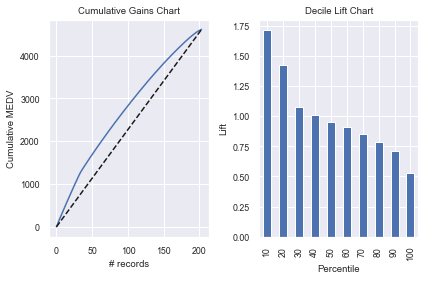

In [94]:
pred_y = pd.Series(housing_lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

pred_y = pd.Series(housing_lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative MEDV')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

** 세번째 모델(모든 예측변수 사용)

In [95]:
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'CAT. MEDV']
outcome = 'MEDV'

# partition data
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y,test_size=0.4, random_state=1)

housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)   #학습 데이터에 대한 모델 구축

# print performance measures
regressionSummary(valid_y, housing_lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.4347
       Root Mean Squared Error (RMSE) : 3.8763
            Mean Absolute Error (MAE) : 2.7696
          Mean Percentage Error (MPE) : -2.2773
Mean Absolute Percentage Error (MAPE) : 13.3233


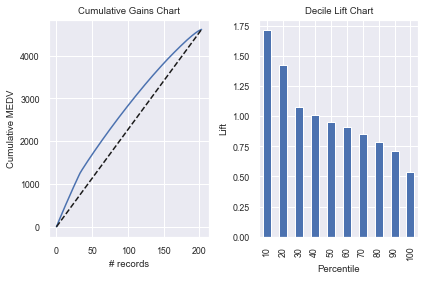

In [96]:
pred_y = pd.Series(housing_lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative MEDV')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

결론 : 모든 예측변수를 사용한 세번째 모델이 ME, RMSE 모두 가장 작으므로 세번째 모델이 가장 좋은 모형이다.  
즉 새로운 데이터에 대한 주택 가격의 중앙값을 예측하려면 13개의 예측변수를 모두 사용하는 것이 좋다.

## 6.2

#### a.

In [17]:
tayko_df = pd.read_csv('D:\숙탯 2기\dmba-datasets\Tayko.csv')
#tayko_df.columns
tayko_df.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0


In [280]:
# 평균

tk_categ = tayko_df.drop(columns=['sequence_number', 'Freq', 'last_update_days_ago', '1st_update_days_ago'])
tk_categ.columns

Index(['US', 'source_a', 'source_c', 'source_b', 'source_d', 'source_e',
       'source_m', 'source_o', 'source_h', 'source_r', 'source_s', 'source_t',
       'source_u', 'source_p', 'source_x', 'source_w', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

In [251]:
tk_categ[['US', 'Spending']].groupby('US').mean()

,Spending
US,
0,101.216524
1,102.924803


In [282]:
tk_categ[['US', 'Spending']].groupby('US').std()

,Spending
US,
0,174.844401
1,189.275664


다른 범주에 대해서도 마찬가지로 구할 수 있음

#### b.

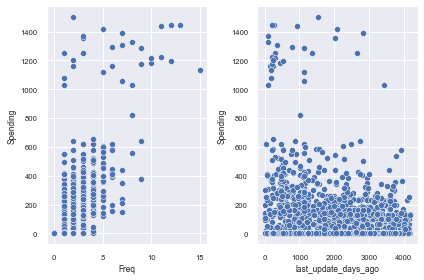

In [18]:
fig, ax = plt.subplots(ncols=2)
sns.scatterplot('Freq', 'Spending', data=tayko_df, ax=ax[0])
sns.scatterplot('last_update_days_ago', 'Spending', data=tayko_df, ax=ax[1])

plt.tight_layout()
plt.show()

Freq 변수와 last_update_days_ago 변수 모두 반응변수 Spending과 선형관계가 아닌 것으로 보인다.

#### c.

i.

In [74]:
predictors = ['Freq', 'last_update_days_ago', 'Web order', 'Gender=male', 'Address_is_res', 'US']
outcome = 'Spending'

X = pd.get_dummies(tayko_df[predictors], drop_first=True)
y = tayko_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

ii.

In [28]:
tk_lm = LinearRegression()
tk_lm.fit(train_X, train_y)

# print coefficients(계수)
print('intercept ', tk_lm.intercept_) 
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': tk_lm.coef_}))

intercept  10.176297413560846
              Predictor  coefficient
0                  Freq    91.274450
1  last_update_days_ago    -0.010374
2             Web order    18.628731
3           Gender=male    -9.111366
4        Address_is_res   -75.815354
5                    US    -4.620293


iii.

전년도 거래 건수가 높고, 고객레코드를 최종갱신한지 오래되었고, 인터넷 구매 기록이 있고, 여성이며,  
주소가 거주지 주소가 아니고, 미국 주소가 아닌 고객

iv.

In [31]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Freq, last_update_days_ago, Web order, Gender=male, Address_is_res, US
Start: score=15028.53
Step: score=15026.76, remove US
Step: score=15026.38, remove Gender=male
Step: score=15026.38, remove None
['Freq', 'last_update_days_ago', 'Web order', 'Address_is_res']


US 변수(미국 주소지인지 여부)가 가장 먼저 탈락된다.

v.

In [76]:
valid_y

674        0
1699     184
1282       0
1315    1289
1210       0
        ... 
1816       0
390      153
1992     133
78       161
1410       0
Name: Spending, Length: 800, dtype: int64

In [78]:
valid_X_1st = pd.DataFrame(valid_X.iloc[0, ]).transpose()
valid_y_1st = valid_y[[674]]
tk_lm_pred = tk_lm.predict(valid_X_1st)

result = pd.DataFrame({'Predicted': tk_lm_pred, 'Actual': valid_y_1st,
                       'Residual': valid_y_1st - tk_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y_1st, tk_lm_pred)

     Predicted  Actual   Residual
674  89.214915       0 -89.214915

Regression statistics

               Mean Error (ME) : -89.2149
Root Mean Squared Error (RMSE) : 89.2149
     Mean Absolute Error (MAE) : 89.2149


vi.

In [67]:
tk_lm_pred = tk_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': tk_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - tk_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, tk_lm_pred)

       Predicted  Actual     Residual
674    89.214915       0   -89.214915
1699  202.231362     184   -18.231362
1282   49.159303       0   -49.159303
1315  824.841659    1289   464.158341
1210    0.121196       0    -0.121196
1636   86.766675       0   -86.766675
613    58.018614       0   -58.018614
447   247.428569    1255  1007.571431
1131   67.036615       0   -67.036615
808    67.825031       0   -67.825031
1496   -7.098168       0     7.098168
1468  194.814024     411   216.185976
1682  -13.480101       0    13.480101
1149  -32.457046       0    32.457046
442    61.247979       0   -61.247979
1813    4.497885     173   168.502115
654   -46.046854       0    46.046854
1264  -32.315195       0    32.315195
858    80.219048       0   -80.219048
1482   51.783900       0   -51.783900

Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


In [81]:
tayko_df['Spending'].value_counts()

0       999
130      39
161      31
128      22
98       19
       ... 
375       1
377       1
166       1
378       1
1500      1
Name: Spending, Length: 363, dtype: int64

In [82]:
tayko_df['Spending'].mean()

102.625

Spending 관측값들의 크기와 비교하였을 때 RMSE가 작지 않으므로 정확도가 높은 모델은 아님.

vii.

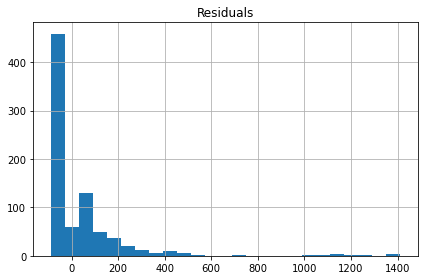

In [84]:
all_residuals = valid_y - tk_lm_pred

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

정규분포를 따르지 않는다. 이는 예측 성능에는 큰 영향을 미치지 않을 수 있다. 하지만 모델 모수들에 대한 신뢰구간 구성 및 통계적 검증을 위해서는 잡음이 정규분포를 따른다는 가정이 성립해야 한다.

## 6.3

In [166]:
df = pd.read_csv('D:\숙탯 2기\dmba-datasets\Airfares.csv')
df

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,LGA,New York/Newark NY,*,West Palm Beach FL,1.08,3,Yes,No,2216.70,32991.0,37375.0,8621121,991717,Controlled,Free,1030,34324,129.63
634,EWR,New York/Newark NY,*,West Palm Beach FL,1.08,0,Yes,No,2216.70,32991.0,37375.0,8621121,991717,Free,Constrained,1030,34324,129.63
635,*,Philadelphia/Camden PA,*,West Palm Beach FL,1.17,3,Yes,No,6797.80,27994.0,37375.0,4948339,991717,Free,Free,960,6016,124.87
636,IAD,Washington DC,*,West Palm Beach FL,1.28,3,Yes,No,5566.43,31981.0,37375.0,4549784,991717,Free,Free,858,4877,129.62


#### a.

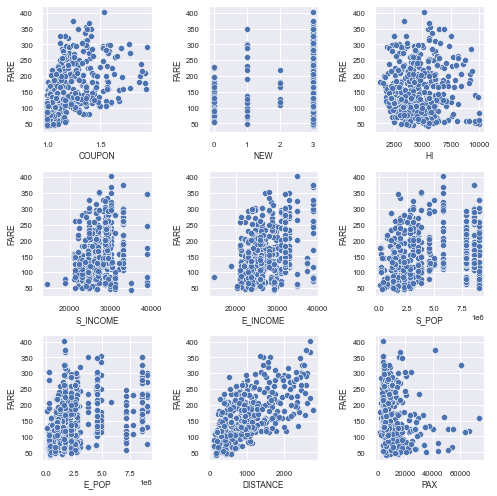

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (7, 7))
sns.scatterplot('COUPON', 'FARE', data=df, ax=ax[0][0])
sns.scatterplot('NEW', 'FARE', data=df, ax=ax[0][1])
sns.scatterplot('HI', 'FARE', data=df, ax=ax[0][2])
sns.scatterplot('S_INCOME', 'FARE', data=df, ax=ax[1][0])
sns.scatterplot('E_INCOME', 'FARE', data=df, ax=ax[1][1])
sns.scatterplot('S_POP', 'FARE', data=df, ax=ax[1][2])
sns.scatterplot('E_POP', 'FARE', data=df, ax=ax[2][0])
sns.scatterplot('DISTANCE', 'FARE', data=df, ax=ax[2][1])
sns.scatterplot('PAX', 'FARE', data=df, ax=ax[2][2])

plt.tight_layout()
plt.show()

COUPON-FARE 산점도와 DISTANCE-FARE 산점도가 가장 선형성을 띄는데  
COUPON-FARE 산점도는 이분산성이 더 뚜렷하게 나타나므로  
DISTANCE 변수가 가장 최적의 예측변수일 것으로 보인다.

#### b.

범주형 변수: 'VACATION', 'SW', 'SLOT', 'GATE'

1) 범주별 백분율

In [203]:
df['VACATION'].value_counts()

No     468
Yes    170
Name: VACATION, dtype: int64

In [278]:
vac_yes = df['VACATION'].value_counts()[1]/df['VACATION'].size
vac_yes = round(100 *  vac_yes, 3)

sw_yes = df['SW'].value_counts()[1]/df['SW'].size
sw_yes = round(100 * sw_yes, 3)

slot_yes = df['SLOT'].value_counts()[1]/df['SLOT'].size
slot_yes = round(100 * slot_yes, 3)

gate_yes = df['GATE'].value_counts()[1]/df['GATE'].size
gate_yes = round(100 * gate_yes, 3)


print(f"휴양지 노선의 비율: {vac_yes}%")
print(f"SW 사가 노선을 제공하는 비율: {sw_yes}%")
print(f"슬롯 통제하는 비율: {slot_yes}%")
print(f"탑승구 제한하는 비율: {gate_yes}%")

휴양지 노선의 비율: 26.646%
SW 사가 노선을 제공하는 비율: 30.408%
슬롯 통제하는 비율: 28.527%
탑승구 제한하는 비율: 19.436%


2) 범주별 평균 운임

** VACATION 변수

In [271]:
df1 = df[df['VACATION']=='Yes']
df2 = df[df['VACATION']=='No']


print("휴양지 노선일 때 평균 운임:", df1['FARE'].mean())
print("휴양지 노선이 아닐 때 평균 운임:", df2['FARE'].mean())


휴양지 노선일 때 평균 운임: 125.98088235294114
휴양지 노선이 아닐 때 평균 운임: 173.55250000000024


** SW 변수

In [272]:
df1 = df[df['SW']=='Yes']
df2 = df[df['SW']=='No']


print("SW 사가 해당 노선을 제공할 때 평균 운임:", df1['FARE'].mean())
print("SW 사가 해당 노선을 제공하지 않을 때 평균 운임:", df2['FARE'].mean())

SW 사가 해당 노선을 제공할 때 평균 운임: 98.3822680412371
SW 사가 해당 노선을 제공하지 않을 때 평균 운임: 188.1827927927929


** SLOT 변수

In [274]:
df1 = df[df['SLOT']=='Controlled']
df2 = df[df['SLOT']=='Free']


print("슬롯 통제할 때 평균 운임:", df1['FARE'].mean())
print("슬롯 통제하지 않을 때 평균 운임:", df2['FARE'].mean())

슬롯 통제할 때 평균 운임: 186.05939560439566
슬롯 통제하지 않을 때 평균 운임: 150.82567982456146


** GATE 변수

In [277]:
df1 = df[df['GATE']=='Constrained']
df2 = df[df['GATE']=='Free']


print("탑승구 제한할 때 평균 운임:", df1['FARE'].mean())
print("탑승구 제한하지 않을 때 평균 운임:", df2['FARE'].mean())

탑승구 제한할 때 평균 운임: 193.1290322580645
탑승구 제한하지 않을 때 평균 운임: 153.09595330739313


SW 변수의 경우 범주에 따라 평균 운임이 크게 달라지므로 운임을 예측하는 데 가장 많은 영향을 미치는 것으로 볼 수 있다.  
(가장 좋은 예측 변수이다.)

??

#### c.

i.

In [75]:
predictors = ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME','E_INCOME',
              'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE', 'PAX']
outcome = 'FARE'

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

lm = LinearRegression()  
lm.fit(train_X, train_y)

# print performance measures
regressionSummary(valid_y, lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -1.8231
       Root Mean Squared Error (RMSE) : 36.0002
            Mean Absolute Error (MAE) : 28.5002
          Mean Percentage Error (MPE) : -6.6037
Mean Absolute Percentage Error (MAPE) : 21.6048


ii.

In [76]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: COUPON, NEW, HI, S_INCOME, E_INCOME, S_POP, E_POP, DISTANCE, PAX, VACATION_Yes, SW_Yes, SLOT_Free, GATE_Free
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW_Yes
Step: score=3913.59, add VACATION_Yes
Step: score=3890.27, add HI
Step: score=3873.33, add GATE_Free
Step: score=3852.81, add SLOT_Free
Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP
Step: score=3821.88, add E_INCOME
Step: score=3821.88, unchanged None
['DISTANCE', 'SW_Yes', 'VACATION_Yes', 'HI', 'GATE_Free', 'SLOT_Free', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']


iii.

In [97]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))).sort_values(by = 'r2adj', ascending=False))
pd.reset_option('display.width')

     n     r2adj          AIC  DISTANCE  E_INCOME  E_POP  GATE_Free     HI    PAX  SLOT_Free  \
10  11  0.773595  3822.798222      True      True   True       True   True   True       True   
9   10  0.773567  3821.876901      True      True   True       True   True   True       True   
8    9  0.770266  3826.433471      True     False   True       True   True   True       True   
7    8  0.765105  3833.945866      True     False   True       True   True   True      False   
6    7  0.758747  3843.170960      True     False   True      False   True   True      False   
5    6  0.751947  3852.808698      True     False  False       True   True  False       True   
4    5  0.737584  3873.328296      True     False  False       True   True  False      False   
3    4  0.724977  3890.268211      True     False  False      False   True  False      False   
2    3  0.706909  3913.585125      True     False  False      False  False  False      False   
1    2  0.605715  4025.892420      True 

단계적 선택방법으로 변수를 선택했을 때와 달리 S_INCOME이 예측변수로 포함된 모형이 최적의 모형으로 제시되었다.

iv.

ii.의 모델

In [78]:
predictors = ['DISTANCE', 'SW_Yes', 'VACATION_Yes', 'HI', 'GATE_Free', 'SLOT_Free', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']
outcome = 'FARE'

In [79]:
df1 = pd.get_dummies(df, drop_first=True)
X = df1[predictors]
y = df1[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

lm = LinearRegression()  
lm.fit(train_X, train_y)

print('intercept ', lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures
regressionSummary(valid_y, lm.predict(valid_X))

intercept  52.89100013731786
      Predictor  coefficient
0      DISTANCE     0.075558
1        SW_Yes   -43.031272
2  VACATION_Yes   -35.865596
3            HI     0.007188
4     GATE_Free   -21.410803
5     SLOT_Free   -13.915304
6           PAX    -0.000829
7         E_POP     0.000004
8         S_POP     0.000004
9      E_INCOME     0.001148

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


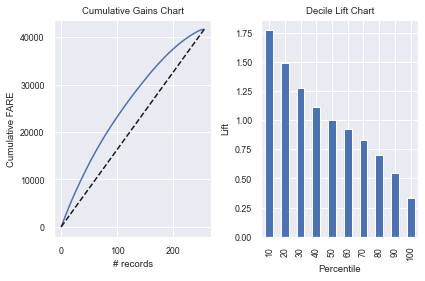

In [104]:
pred_y = pd.Series(lm.predict(valid_X)).sort_values(ascending=False)

pred_y = pd.Series(lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative FARE')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

iii.의 모델

In [121]:
predictors = ['DISTANCE', 'E_INCOME', 'E_POP', 'GATE_Free', 'HI', 'PAX', 'SLOT_Free', 'SW_Yes', 'S_INCOME', 'S_POP', 'VACATION_Yes']
outcome = 'FARE'

In [122]:
_ = pd.get_dummies(df, drop_first=True)
X = _[predictors]
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

lm = LinearRegression()  
lm.fit(train_X, train_y)

print('intercept ', lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures
regressionSummary(valid_y, lm.predict(valid_X))

intercept  31.378580298313977
       Predictor  coefficient
0       DISTANCE     0.075241
1       E_INCOME     0.001229
2          E_POP     0.000004
3      GATE_Free   -20.964865
4             HI     0.007133
5            PAX    -0.000857
6      SLOT_Free   -13.113731
7         SW_Yes   -41.642117
8       S_INCOME     0.000662
9          S_POP     0.000004
10  VACATION_Yes   -34.656294

Regression statistics

                      Mean Error (ME) : -1.8424
       Root Mean Squared Error (RMSE) : 35.9030
            Mean Absolute Error (MAE) : 28.3317
          Mean Percentage Error (MPE) : -6.6938
Mean Absolute Percentage Error (MAPE) : 21.4834


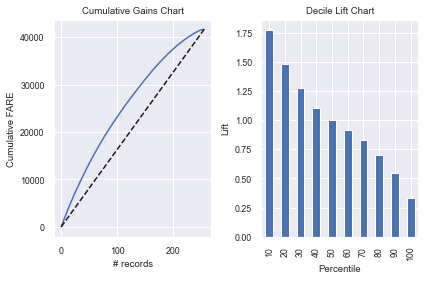

In [107]:
pred_y = pd.Series(lm.predict(valid_X)).sort_values(ascending=False)

pred_y = pd.Series(lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative FARE')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

RMSE와 ME 모두 (iii)의 모델이 더 작으므로 예측 정확도는 (iii)의 모델이 더 높다.

v.

In [123]:
x = pd.DataFrame([[1976, 27664, 3195503, 1, 4442.141, 12782, 1, 0, 28760, 4557004, 0]],
                columns=['DISTANCE', 'E_INCOME', 'E_POP', 'GATE_Free', 'HI', 'PAX', 'SLOT_Free',
                         'SW_Yes', 'S_INCOME', 'S_POP', 'VACATION_Yes'])

print("평균 운임의 예측값: ", lm.predict(x)[0])

평균 운임의 예측값:  251.6309646108928


vi.

In [129]:
x = pd.DataFrame([[1976, 27664, 3195503, 1, 4442.141, 12782, 1, 1, 28760, 4557004, 0]],
                columns=['DISTANCE', 'E_INCOME', 'E_POP', 'GATE_Free', 'HI', 'PAX', 'SLOT_Free',
                         'SW_Yes', 'S_INCOME', 'S_POP', 'VACATION_Yes'])

print("평균 운임의 예측값: ", lm.predict(x)[0])

평균 운임의 예측값:  209.98884735522105


In [128]:
감소율 = round(100 * (1- 209.98884735522105 / 251.6309646108928), 4)
print("감소율: ", 감소율)

감소율:  16.5489


vii.

시장점유율, 공항 체증의 정도, 승객 수는 항공편을 운행해야만 생성되는 데이터이므로 HI, SLOT, GATE, PAX는 예측변수에서 제외해야 한다.

viii.

In [156]:
#HI, SLOT, GATE, PAX는 예측변수에서 제외
predictors = ['COUPON',
 'NEW',
 'VACATION',
 'SW',
 'S_INCOME',
 'E_INCOME',
 'S_POP',
 'E_POP',
 'DISTANCE']

outcome = 'FARE'

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [159]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))).sort_values(by = 'r2adj', ascending=False))
pd.reset_option('display.width')

   n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP    NEW  SW_Yes  S_INCOME  S_POP  \
5  6  0.719851  3899.290607   False      True      True   True  False    True     False   True   
6  7  0.719412  3900.868554   False      True      True   True  False    True      True   True   
7  8  0.718788  3902.694182   False      True      True   True   True    True      True   True   
8  9  0.718045  3904.676636    True      True      True   True   True    True      True   True   
4  5  0.716405  3902.977542   False      True     False   True  False    True     False   True   
3  4  0.712897  3906.688826   False      True      True  False  False    True     False  False   
2  3  0.706909  3913.585125   False      True     False  False  False    True     False  False   
1  2  0.605715  4025.892420   False      True     False  False  False    True     False  False   
0  1  0.453107  4149.881509   False      True     False  False  False   False     False  False   

   VACATION_Yes  
5

전역탐색 결과에 따라 DISTANCE, E_INCOME, E_POP, SW_Yes, S_INCOME, S_POP, VACATION_Yes를 예측변수로 포함하는 회귀식을 추정하자.

In [142]:
predictors = ['DISTANCE', 'E_INCOME', 'E_POP', 'SW_Yes', 'S_INCOME', 'S_POP', 'VACATION_Yes']
outcome = 'FARE'

_ = pd.get_dummies(df, drop_first=True)
X = _[predictors]
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

lm = LinearRegression()  
lm.fit(train_X, train_y)

print('intercept ', lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

intercept  60.644249573360725
      Predictor  coefficient
0      DISTANCE     0.069963
1      E_INCOME     0.001177
2         E_POP     0.000002
3        SW_Yes   -54.481458
4      S_INCOME     0.000451
5         S_POP     0.000002
6  VACATION_Yes   -46.700684


ix. 

In [141]:
x = pd.DataFrame([[1976, 27664, 3195503, 0, 28760, 4557004, 0]],
                columns=['DISTANCE', 'E_INCOME', 'E_POP', 
                         'SW_Yes', 'S_INCOME', 'S_POP', 'VACATION_Yes'])

print("평균 운임의 예측값: ", lm.predict(x)[0])

평균 운임의 예측값:  260.6054398746783


x.

In [143]:
# print performance measures
regressionSummary(valid_y, lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.6910
       Root Mean Squared Error (RMSE) : 41.4199
            Mean Absolute Error (MAE) : 33.4703
          Mean Percentage Error (MPE) : -7.4514
Mean Absolute Percentage Error (MAPE) : 24.5778


(iii)의 모델에 비해 ME는 작고 RMSE는 크다.

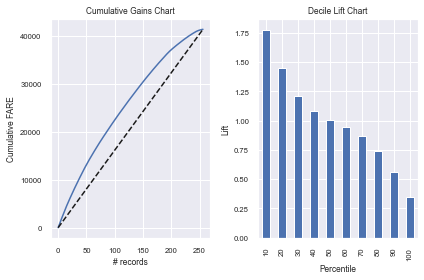

In [144]:
pred_y = pd.Series(lm.predict(valid_X)).sort_values(ascending=False)

pred_y = pd.Series(lm.predict(valid_X))
pred_y = pred_y.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_y, ax=axes[0])
ax.set_ylabel('Cumulative FARE')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(pred_y, ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()

#### d.

SW_Yes = 0 일 때와 SW_Yes = 1일 때 운임의 차이 비교에 초점을 맞췄을 것임.  
(v), (vi) : 사우스웨스트사가 이 노선을 운행하게 되면(SY_Yes=1), 평균 운임이 약 42달러 감소 
* 개념적 측면?

## 6.4

In [172]:
car_df = pd.read_csv('D:\숙탯 2기\dmba-datasets\ToyotaCorolla.csv')
car_df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


In [194]:
predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 
              'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco',
             'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Tow_Bar']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.3, random_state=1)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.25)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients(계수)
print('intercept ', car_lm.intercept_)  #intercept : 절편
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

intercept  9294.415165936436
           Predictor  coefficient
0          Age_08_04  -110.370535
1                 KM    -0.018642
2                 HP    36.190093
3          Automatic   613.026779
4              Doors   127.288903
5      Quarterly_Tax    18.091083
6      Mfr_Guarantee   165.222134
7   Guarantee_Period    78.360435
8              Airco   163.648668
9    Automatic_airco  3359.056824
10         CD_Player   229.944094
11   Powered_Windows   433.881347
12       Sport_Model   348.570215
13           Tow_Bar  -210.146959
14  Fuel_Type_Diesel  2092.439468
15  Fuel_Type_Petrol  2149.887102


#### a.

In [195]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))).sort_values(by = 'r2adj', ascending=False))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Airco  Automatic  Automatic_airco  CD_Player  Doors  \
15  16  0.885533  18380.884518       True   True       True             True       True   True   
14  15  0.885314  18381.962650       True  False       True             True       True   True   
13  14  0.884969  18384.204047       True  False       True             True       True   True   
12  13  0.884480  18387.793208       True  False       True             True      False   True   
11  12  0.883943  18391.797161       True  False       True             True      False   True   
10  11  0.883047  18399.094119       True  False       True             True      False  False   
9   10  0.881714  18410.308252       True  False       True             True      False  False   
8    9  0.880322  18421.918007       True  False      False             True      False  False   
7    8  0.878007  18441.564226       True  False      False             True      False  False   
6    7  0.876238  18

#### b.

In [184]:
# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1225.5361
            Mean Absolute Error (MAE) : 913.3999
          Mean Percentage Error (MPE) : -0.9837
Mean Absolute Percentage Error (MAPE) : 9.0310


In [185]:
regressionSummary(valid_y, car_lm.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -34.3015
       Root Mean Squared Error (RMSE) : 1154.1800
            Mean Absolute Error (MAE) : 896.1363
          Mean Percentage Error (MPE) : -1.2820
Mean Absolute Percentage Error (MAPE) : 8.9632


In [186]:
regressionSummary(test_y, car_lm.predict(test_X))


Regression statistics

                      Mean Error (ME) : -0.8015
       Root Mean Squared Error (RMSE) : 1208.1159
            Mean Absolute Error (MAE) : 924.4362
          Mean Percentage Error (MPE) : -0.9902
Mean Absolute Percentage Error (MAPE) : 9.1920
